# Data Preparation

In [1]:
from numpy import asarray
from numpy import save
from predictor.driver import Predictor
from predictor.src import utils
from predictor.driver import Predictor
from predictor.src import utils

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

training_data, names_list, scores_list = utils.load_training_data()
X, y = zip(*training_data)
X = list(X)
y = list(y)
for i in range(len(X)):
    X[i] = list(X[i])
    scores_list[i] = list(scores_list[i])

X, y, indices = np.array(X), np.array(y), np.array(range(len(y)))

non_zero_indices = []
for i in range(len(X[0])):
    if sum(X[:, i]) > 0:
        non_zero_indices.append(i)
X = X[:, non_zero_indices]

(
    X_train,
    X_test,
    y_train,
    y_test,
    indices_train,
    indices_test,
) = train_test_split(X, y, indices, test_size=0.3, random_state=5)

scores_filtered = [scores_list[i] for i in indices_test]
names_filtered = [names_list[i] for i in indices_test]

# scaler = preprocessing.StandardScaler().fit(X_train)
# in_max_scaler = preprocessing.MinMaxScaler()

# X_train = preprocessing.normalize(X_train, norm='l2')

# m = np.mean(X_train, axis=0) # array([16.25, 26.25])
# std = np.std(X_train, axis=0) # array([17.45530005, 22.18529919])

# X_train = 0.5 * (np.tanh(0.01 * ((X_train - m) / std)) + 1)

predictor = Predictor()
performance = []

In [2]:
utils.init_all_config_files()
path = (
    "/Users/nils/Documents/repos/MQTPredictor/comp_test/wstate_indep_qiskit_127_0.qasm"
)
utils.calc_eval_score_for_qc(path, "ibm_washington")

0.0

In [3]:
for indx, elem in enumerate(names_list):
    qubit = elem.split(".")[0].split("_")[-1]
    if int(qubit) > 80:
        print(qubit, elem, scores_list[indx])

94 dj_indep_qiskit_94 [-10000.0, -10000.0, -10000.0, 1.4910425386548638e-07, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0]
94 dj_indep_tket_94 [-10000.0, -10000.0, -10000.0, 1.4910425386548638e-07, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0]


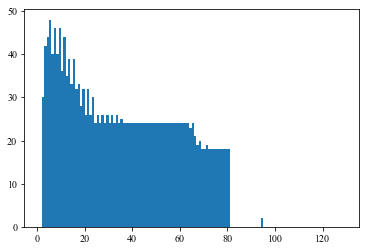

In [4]:
import matplotlib.pyplot as plt

plt.hist(X[:, -7], bins=range(1, 130, 1));

# Random Forest

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


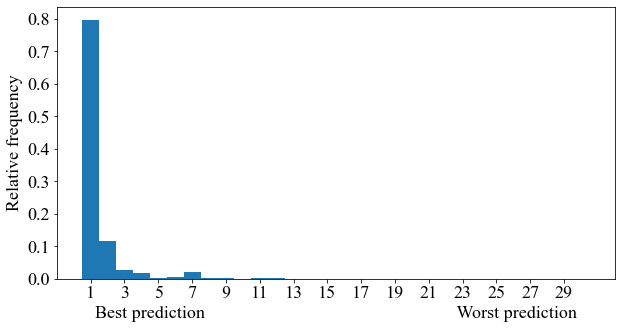

Best Accuracy:  0.764974112511899
Top 3:  0.9428571428571428
Feature Importance:  [4.71472645e-02 7.99072841e-03 3.49605841e-04 7.32689613e-02
 4.56102561e-03 2.93930949e-04 8.89391725e-03 3.24398939e-02
 1.30373182e-03 6.34606971e-03 5.60109704e-03 1.48751183e-02
 2.28169924e-03 2.48334664e-04 5.51960385e-04 3.74365054e-04
 2.39715939e-02 3.59857580e-05 1.20990459e-03 3.78380454e-04
 1.68076944e-01 9.33411378e-02 6.06406596e-02 1.05449242e-01
 1.15335597e-01 1.14758832e-01 1.10274019e-01]


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(random_state=0)

tree_param = [
    {
        "n_estimators": [100, 200, 500],
        "max_features": ["auto", "sqrt"],
        "max_depth": list(range(8, 30, 6)),
        "min_samples_split": list(range(2, 20, 6)),
        "min_samples_leaf": list(range(2, 20, 6)),
        "bootstrap": [True, False],
    },
]

clf = GridSearchCV(clf, tree_param, cv=5, n_jobs=8).fit(X_train, y_train)


y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(
    scores_filtered, y_pred, y_test, filename="RandomForestClassifier"
)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Feature Importance: ", clf.best_estimator_.feature_importances_)
performance.append(("RandomForestClassifier", clf.best_score_, top3, max(res)))

### Feature Importances

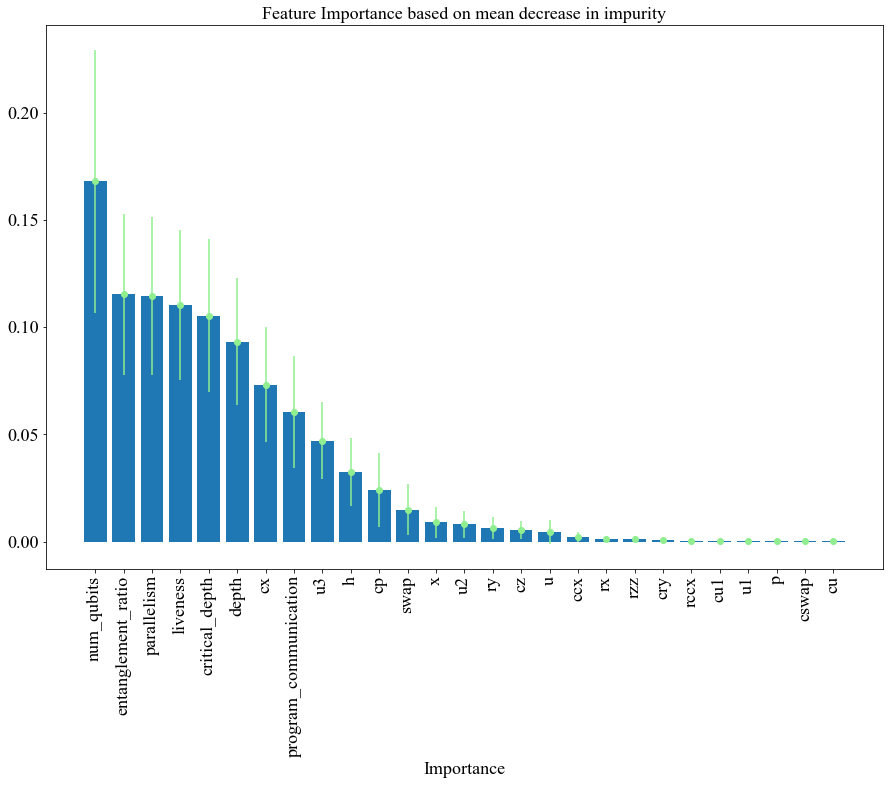

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

openqasm_qc_list = utils.get_openqasm_gates()
feature_names = [openqasm_qc_list[i] for i in range(0, len(openqasm_qc_list))]
feature_names.append("num_qubits")
feature_names.append("depth")
feature_names.append("program_communication")
feature_names.append("critical_depth")
feature_names.append("entanglement_ratio")
feature_names.append("parallelism")
feature_names.append("liveness")
feature_names = [feature_names[i] for i in non_zero_indices]

importances = clf.best_estimator_.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in clf.best_estimator_.estimators_], axis=0
)

idx = np.argsort(-importances)

plt.figure(figsize=(15, 10))
plt.bar(np.array(feature_names)[idx], np.array(importances)[idx])
plt.errorbar(
    np.array(feature_names)[idx],
    np.array(importances)[idx],
    np.array(std)[idx],
    fmt="o",
    color="lightgreen",
)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.title("Feature Importance based on mean decrease in impurity", fontsize=18)
plt.xlabel("Feature", fontsize=18)
plt.xlabel("Importance", fontsize=18)
plt.savefig("feature_importances.pdf")
plt.show()

# Entries Graph:  630


/Users/nils/Documents/repos/MQTPredictor/predictor/driver.py:370: RuntimeWarning: overflow encountered in double_scalars
  plt.plot(i, tmp_res[j] / max_score, "b.", alpha=1.0, markersize=1.7)
/Users/nils/Documents/repos/MQTPredictor/predictor/driver.py:374: RuntimeWarning: overflow encountered in double_scalars
  tmp_res[y_pred_sorted_accordingly[i]] / max_score,


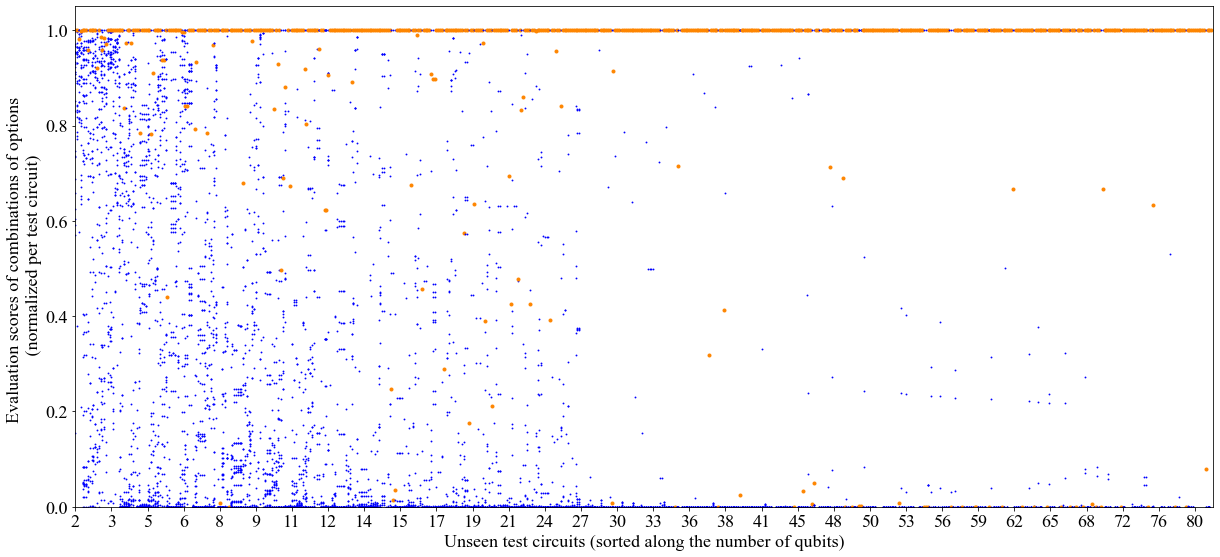

In [7]:
predictor.plot_eval_all_detailed_compact_normed(
    names_filtered, scores_filtered, y_pred, y_test
)

# GradientBoostingClassifier

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


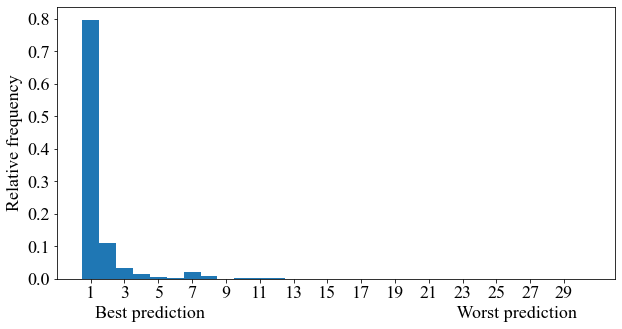

Best Accuracy:  0.7602122077499942
Top 3:  0.9396825396825397


In [8]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()

param_grid = {
    "learning_rate": [0.01, 0.1, 1],
}

clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(
    scores_filtered, y_pred, y_test, filename="GradientBoostingClassifier"
)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("GradientBoostingClassifier", clf.best_score_, top3, max(res)))

# Current Decision Tree Classifier

In [9]:
# predictor.train_decision_tree_classifier(X, y, names_list, scores_list);

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


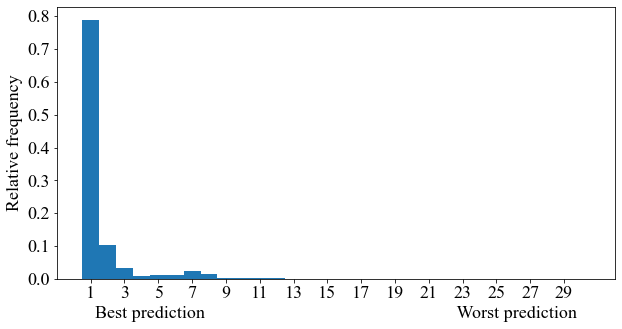

Best Accuracy:  0.7397668965197
Top 3:  0.9238095238095239
Feature Importance:  [0.0114614  0.00219981 0.         0.06642992 0.         0.
 0.00250642 0.01962006 0.00095684 0.         0.         0.
 0.00104792 0.         0.         0.         0.         0.
 0.         0.         0.43893541 0.05903139 0.0309124  0.07913554
 0.09867927 0.11509655 0.07398707]


In [10]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

clf = tree.DecisionTreeClassifier(random_state=5)

tree_param = [
    {
        "criterion": ["entropy", "gini"],
        "max_depth": list(range(1, 15, 1)),
        "min_samples_split": list(range(2, 20, 4)),
        "min_samples_leaf": list(range(2, 20, 4)),
        "max_leaf_nodes": list(range(2, 200, 40)),
        "max_features": list(range(1, len(non_zero_indices), 10)),
    },
]
clf = GridSearchCV(clf, tree_param, cv=5, n_jobs=8).fit(X_train, y_train)
y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(
    scores_filtered, y_pred, y_test, filename="DecisionTreeClassifier"
)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Feature Importance: ", clf.best_estimator_.feature_importances_)
performance.append(("DecisionTreeClassifier", clf.best_score_, top3, max(res)))

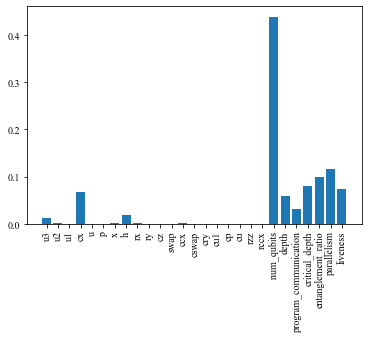

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

openqasm_qc_list = utils.get_openqasm_gates()
feature_names = [openqasm_qc_list[i] for i in range(0, len(openqasm_qc_list))]
feature_names.append("num_qubits")
feature_names.append("depth")
feature_names.append("program_communication")
feature_names.append("critical_depth")
feature_names.append("entanglement_ratio")
feature_names.append("parallelism")
feature_names.append("liveness")
feature_names = [feature_names[i] for i in non_zero_indices]

plt.bar(feature_names, clf.best_estimator_.feature_importances_)
plt.xticks(rotation=90)
plt.show()

# Nearest Neighbor

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


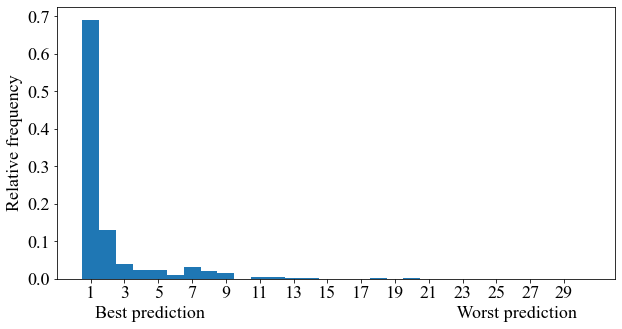

Best Accuracy:  0.6811891992291799
('Top 3: ', 0.8603174603174604)


In [12]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
param_grid = dict(n_neighbors=range(1, 10, 1))
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(
    scores_filtered, y_pred, y_test, filename="KNeighborsClassifier"
)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print(("Top 3: ", top3))
performance.append(("KNeighborsClassifier", clf.best_score_, top3, max(res)))

# SVM

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


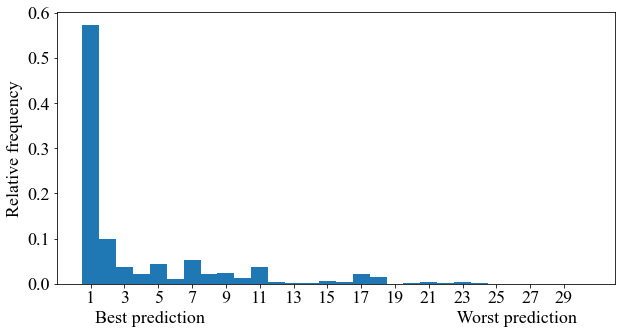

Best Accuracy:  0.5531099811938427
Top 3:  0.7095238095238096


In [13]:
from sklearn import svm

clf = svm.SVC()
param_grid = {"C": [0.1, 1, 10], "gamma": [1, 0.1, 0.01], "kernel": ["rbf", "sigmoid"]}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test, filename="SVM")

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("SVM", clf.best_score_, top3, max(res)))

# Naive Bayes

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


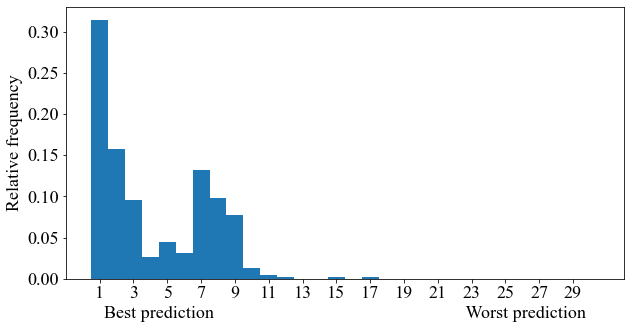

Best Accuracy:  0.28340646838940353
Top 3:  0.5666666666666667


In [14]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
param_grid = {"var_smoothing": np.logspace(0, -9, num=100)}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(
    scores_filtered, y_pred, y_test, filename="GaussianNB"
)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("GaussianNB", clf.best_score_, top3, max(res)))

# SGD

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


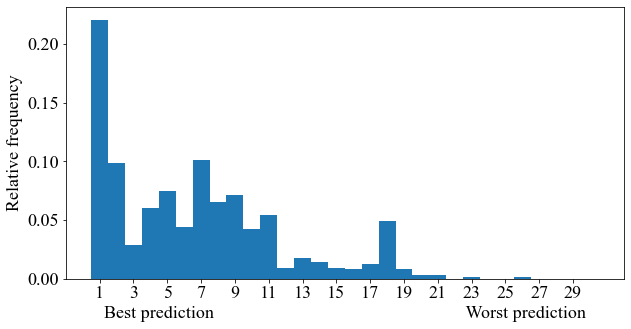

Best Accuracy:  0.21857166074620976
Top 3:  0.3476190476190476


In [15]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=200)

param_grid = {
    "average": [True, False],
    "l1_ratio": np.linspace(0, 1, num=10),
    "alpha": np.power(10, np.arange(-2, 1, dtype=float)),
}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(
    scores_filtered, y_pred, y_test, filename="SGDClassifier"
)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("SGDClassifier", clf.best_score_, top3, max(res)))

# Save Performance Results

In [16]:
print(performance)

filename = "performances.csv"
with open(filename, "w") as f:
    f.write("ML Algorithm, Accuracy, Top3, Worst Rank\n")
    for sublist in performance:
        line = "{}, {}, {}, {} \n".format(
            sublist[0], sublist[1], sublist[2], sublist[3]
        )
        f.write(line)

[('RandomForestClassifier', 0.764974112511899, 0.9428571428571428, 12), ('GradientBoostingClassifier', 0.7602122077499942, 0.9396825396825397, 12), ('DecisionTreeClassifier', 0.7397668965197, 0.9238095238095239, 12), ('KNeighborsClassifier', 0.6811891992291799, 0.8603174603174604, 20), ('SVM', 0.5531099811938427, 0.7095238095238096, 24), ('GaussianNB', 0.28340646838940353, 0.5666666666666667, 17), ('SGDClassifier', 0.21857166074620976, 0.3476190476190476, 26)]


# Debugging